In [1]:
def factorial(n):
    if n in [0, 1]:
        return 1
    else:
        r = 1
        for i in range(2, n+1):
            r *= i
        return r

# число перестановок N объектов
def P(n):
    return factorial(n)

# число упорядоченных(!) подмножеств размера k у множества размера N
def A(n, k):
    return P(n) // P(n - k)

# число НЕупорядоченных(!) подмножеств размера k у множества размера N
def C(n, k):
    return A(n, k) // P(k)

In [2]:
# размер доски
side = 11
# сколько нужно собрать в ряд, чтобы победить
in_row = 5
# число полей
cell_count = side ** 2
options = 'xo '
# верхняя оценка числа позиций
upper_limit = len(options) ** cell_count
print("Верхняя граница оценки числа позиций игры гомоку =\n", upper_limit)

upper_limit = 0
for occupied_count in range(0, cell_count+1):
    o_s = occupied_count // 2
    upper_limit += C(cell_count, occupied_count) * C(occupied_count, o_s)

print("Более точная оценка числа позиций =\n", upper_limit) 

Верхняя граница оценки числа позиций игры гомоку =
 5391030899743293631239539488528815119194426882613553319203
Более точная оценка числа позиций =
 476711683472917820342007703293332718385747007654654589722


In [3]:
# оценим сверху, сколько позиций нужно перебрать для просмотра на depth ходов вперёд
def get_estimations(free_pos, depth):
    return [
        A(free_pos, x) // P(x // 2) // P(x - x // 2)
        for x
        in range(1, depth+1)
    ]

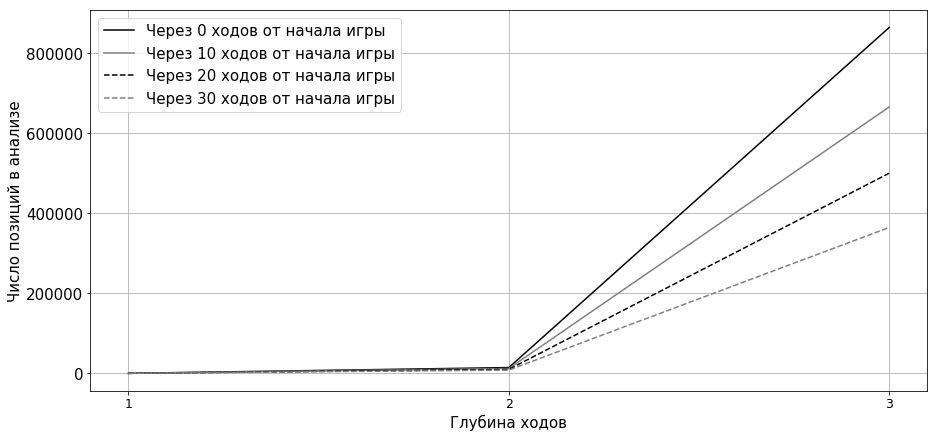

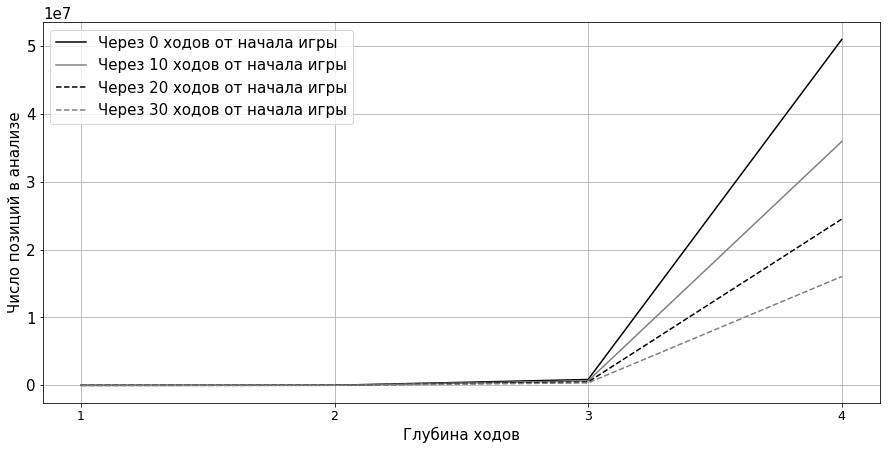

In [5]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})

graph_presets = [
    (0, 'black', '-'),
    (10, 'gray', '-'),
    (20, 'black', '--'),
    (30, 'gray', '--'),
]

for depth in [3, 4]:
    plt.figure(figsize=(15,7))
    for start, color, style in graph_presets:
        points = get_estimations(side ** 2 - start, depth)
        plt.plot(points,label='Через ' + str(start) + ' ходов от начала игры', color=color, linestyle=style)
    plt.xticks(range(0,depth), range(1, depth+1), size='small')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Глубина ходов')
    plt.ylabel('Число позиций в анализе')
    plt.show()

In [6]:
def print_field(field):
    for i in range(side):
        print(field[i * side:(i + 1) * side].replace(' ', '.'))

# для линии из 5 x, o, ' ' сгенерируем её различные положения на доске
def gen(line):
    wins = set()
    RL = len(line)
    # горизонтали
    for j in range(side - RL + 1):
        for i in range(side):
            empty1 = ' ' * (side * i)
            winrow = (' ' * j) + line + (' ' * (side - j - RL))
            empty2 = ' ' * (side * (side - i - 1))
            wins.add(empty1 + winrow + empty2)
    # вертикали
    for j in range(side - RL + 1):
        for i in range(side):
            empty1 = (' ' * side * j)
            winrows = ""
            for ch in line:
                winrows += (' ' * i) + ch + (' ' * (side - i - 1))
            empty2 = ' ' * (side * (side - j - RL))
            wins.add(empty1 + winrows + empty2)
    #diagonal 
    for x in range(side - RL + 1):
        for y in range(side - RL + 1):
            s1 = ' ' * (side ** 2)
            s2 = ' ' * (side ** 2)
            for d in range(RL):
                _x, _y = x + d, y + d
                s1 = s1[:_x * side + _y] + line[d] + s1[_x * side + _y+1:]
                _x, _y = x + (in_row - d - 1), y + d
                s2 = s2[:_x * side + _y] + line[d] + s2[_x * side + _y+1:]
            wins.add(s1)
            wins.add(s2)
    return wins

# выигрышные комбинации для крестиков и ноликов
xwintmp = gen('x' * in_row)
owintmp = gen('o' * in_row)
if len(list(filter(lambda f: f.count('x') != in_row, xwintmp))):
    print("Ошибка валидации")
# некоторые тройки и четвёрки, представляющие опасность в игре
xthreat = gen('xxxx.') | gen('.xxxx') | gen('.xxx.') | gen('x.xxx') | gen('xx.xx') | gen('xxx.x')
othreat = gen('oooo.') | gen('.oooo') | gen('.ooo.') | gen('o.ooo') | gen('oo.oo') | gen('ooo.o')

def is_subfield(bigger, smaller):
    return all(map(lambda a, b: (a == b) or (a == ' ' and b == '.') or (b == ' '), bigger, smaller))

def is_win(field, who):
    expected = xwintmp if who == 'x' else owintmp
    return any(map(lambda tmp: is_subfield(field, tmp), expected))

def count_wins(field, who):
    expected = xwintmp if who == 'x' else owintmp
    return sum(map(lambda tmp: is_subfield(field, tmp), expected))

def count_threats(field, who):
    expected = xthreat if who == 'x' else othreat
    return sum(map(lambda tmp: is_subfield(field, tmp), expected))

In [7]:
# построим поля, которые можно получить из текущего
def get_children(field):
    result = set()
    char = 'x' if field.count('x') == field.count('o') else 'o'
    for i in range(len(field)):
        if field[i] == ' ':
            result.add(field[:i] + char + field[i+1:])
    return result

# построим множество потомков глубины N
def get_N_moves_descendants(field, N):
    descendants = get_children(field)
    for i in range(N-1):
        new_descendants = set()
        for descendant in descendants:
            new_descendants |= get_children(descendant)
        descendants = new_descendants
    return set(descendants)

In [8]:
# если хочется сделать эту часть более крутой, то лучше всего почитать про алгоритм Минимакс
def find_answer(field):
    who = 'x' if field.count('x') == field.count('o') else 'o'
    enemy = 'x' if who == 'o' else 'o'
    print('Ход', who)
    # если играет крестик - его цель xwin
    target_set = owintmp if who == 'o' else xwintmp
    afraid_set = xthreat if who == 'o' else othreat
    # среди непосредственных потомков ищем победные ходы
    children = get_children(field)
    winning = set(filter(lambda child: is_win(child, who), children))
    if winning:
        return list(winning)[0]
    else:
        candidates = children
        #1 удалим плохие ходы, которые приведут к поражению от следующего хода противника
        print("Поиск на 2 хода вперёд...")
        desc2 = get_N_moves_descendants(field, 2)
        print("Найдено", len(desc2), "позиций")
        print("Отбор опасных позиций...")
        to_remove = set()
        problems = set(filter(lambda child2: is_win(child2, enemy), desc2))
        for candidate in candidates:
            if any(map(lambda problem: is_subfield(problem, candidate), problems)):
                to_remove.add(candidate)
        print("Найдено", len(to_remove), "опасных позиций")
        candidates -= to_remove
        # если ходов не осталось, выходим разочаровано
        print("Осталось", len(candidates), "относительно безопасных ходов")
        if not candidates:
            return "Сдаюсь, " + who
        # дальше начинается "стратегия". Выберем простую.
        # Для каждого хода посчитаем число ХОРОШИХ и ПОБЕДНЫХ (с весом 5) позиций 
        # и вычтем число ПЛОХИХ и ПРОИГРЫШНЫХ (с весом 5) после 3 ходов
        wins = dict((candidate, 0) for candidate in candidates)
        losses = dict((candidate, 0) for candidate in candidates)
        ahead = 2
        count = 0
        print("Начинаем поиск на", ahead, "хода вперёд...")
        for candidate in candidates:
            count += 1
            print(count,"|",sep='',end='',flush=True)
            descendants = get_N_moves_descendants(candidate, ahead - 1)
          
            for descendant in descendants:
                tcw = count_threats(descendant, who)
                wcw = count_wins(descendant, who)
                tce = count_threats(descendant, enemy)
                wce = count_wins(descendant, enemy)
                for candidate in candidates:
                    if is_subfield(descendant, candidate):
                        wins[candidate] += tcw + wcw * 5
                        losses[candidate] += tce + wce * 5

        r = sorted(candidates, key=lambda c: wins[c] - losses[c], reverse=True)
        print("\nОценка хороших исходов", wins[r[0]], "; Оценка плохих исходов", losses[r[0]])
        return r[0]

In [8]:
side = 10
in_row = 5
cell_count = side ** 2
# выигрышные комбинации для крестиков и ноликов
xwintmp = gen('x' * in_row)
owintmp = gen('o' * in_row)
# некоторые тройки и четвёрки, представляющие опасность в игре - их нужно опасаться
xthreat = gen('xxxx.') | gen('.xxxx') | gen('.xxx.') | gen('x.xxx') | gen('xx.xx') | gen('xxx.x')
othreat = gen('oooo.') | gen('.oooo') | gen('.ooo.') | gen('o.ooo') | gen('oo.oo') | gen('ooo.o')

# возьмём уже разыгранную позицию
field = ('...........x.....................xxo......oxxx....xooooxo...........................................'.replace('.', ' '))
# предложим алгоритму доиграть самому собой
while field != "Сдаюсь" and field.count(' ') > 0:
    print_field(field)
    who = 'x' if field.count(' ') % 2 == 1 else 'o'
    field = find_answer(field)
    if is_win(field, who):
        print("ПОБЕДА", who)
        print_field(field)
        break
else:
    if field[:6] != "Сдаюсь":
        print_field(field)
    else:
        print("Противник сдался")

..........
.x........
..........
...xxo....
..oxxx....
xooooxo...
..........
..........
..........
..........
Ход o
Поиск на 2 хода вперёд...
Найдено 7140 позиций
Отбор опасных позиций...
Найдено 84 опасных позиций
Осталось 1 относительно безопасных ходов
Начинаем поиск на 2 хода вперёд...
1|
Оценка хороших исходов 0 ; Оценка плохих исходов 4
..........
.x........
..o.......
...xxo....
..oxxx....
xooooxo...
..........
..........
..........
..........
Ход x
Поиск на 2 хода вперёд...
Найдено 6972 позиций
Отбор опасных позиций...
Найдено 0 опасных позиций
Осталось 84 относительно безопасных ходов
Начинаем поиск на 2 хода вперёд...
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|
Оценка хороших исходов 82 ; Оценка плохих исходов 7
..........
.x........
..o.......
...xxo....
..oxxxx...
xooooxo...
..

In [9]:
# обратите внимание, что крестики проиграли не очень красиво, "прохлопав" вертикальный выигрыш ноликов.
# Это потому, что во множестве othreat не было комбинации '.o.oo.' - открытой псевдо-тройки.
# Если их добавить, игра будет идти очень долго :)